In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

D0704 16:06:49.569025910    3577 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0704 16:06:49.569048619    3577 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0704 16:06:49.569051889    3577 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0704 16:06:49.569054600    3577 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0704 16:06:49.569056961    3577 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0704 16:06:49.569059507    3577 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0704 16:06:49.569061961    3577 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0704 16:06:49.

In [2]:
gpus=tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
print("Ready")

Ready


In [3]:
len(gpus)

0

In [4]:
BATCH = 4
IMG_SIZE = 256
NUM_CLASSES = 6

In [5]:
directory = '/kaggle/input/intel-image-classification/seg_train/seg_train'

In [6]:
train,val = tf.keras.utils.image_dataset_from_directory(
    directory,
    batch_size=BATCH,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    subset='both',
    validation_split = 0.2,
    seed=42
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.


In [7]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_data = train.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val.cache().prefetch(buffer_size=AUTOTUNE)

# Preprocessing pipeline: MCSHBP
map
cache
shuffle
batch
prefetch

In [8]:
resize_and_scale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.2)
# ])

In [9]:
# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model's weights
base_model.trainable = False

# Create a new model on top of the base model
model = tf.keras.Sequential([
    resize_and_scale,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

model.build((BATCH,IMG_SIZE,IMG_SIZE,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (4, 256, 256, 3)          0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (4, 1280)                0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (4, 128)                  163968    
                                                                 
 dense_1 (Dense)             (4, 6)                    774       
                                                                 
Total params: 2,422,726
Trainable params: 164,742
Non-

In [ ]:
# # Configure the dataset for performance
# AUTOTUNE = tf.data.AUTOTUNE
# train_data = train.cache().prefetch(buffer_size=AUTOTUNE)
# val_data = val.cache().prefetch(buffer_size=AUTOTUNE)

# # Create the CNN model
# model = tf.keras.models.Sequential([
#     resize_and_scale,
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

# model.build((BATCH,IMG_SIZE,IMG_SIZE,3))
# model.summary()


In [11]:
# Train the model
history = model.fit(train_data, validation_data=val_data,batch_size = BATCH ,epochs=5)

Epoch 1/5
2807/2807 [==============================] - 153s 53ms/step - loss: 0.3270 - accuracy: 0.8805 - val_loss: 0.2826 - val_accuracy: 0.9031
Epoch 2/5
2807/2807 [==============================] - 148s 53ms/step - loss: 0.2286 - accuracy: 0.9147 - val_loss: 0.2718 - val_accuracy: 0.9084
Epoch 3/5
2807/2807 [==============================] - 149s 53ms/step - loss: 0.1842 - accuracy: 0.9322 - val_loss: 0.2666 - val_accuracy: 0.9088
Epoch 4/5
2807/2807 [==============================] - 149s 53ms/step - loss: 0.1564 - accuracy: 0.9418 - val_loss: 0.3160 - val_accuracy: 0.8984
Epoch 5/5
2807/2807 [==============================] - 149s 53ms/step - loss: 0.1264 - accuracy: 0.9505 - val_loss: 0.3167 - val_accuracy: 0.9041


In [12]:
test = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/intel-image-classification/seg_test/seg_test',
    batch_size=BATCH,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=42
)

Found 3000 files belonging to 6 classes.


In [14]:
model.evaluate(test)

750/750 [==============================] - 33s 44ms/step - loss: 0.3177 - accuracy: 0.9057


[0.3177105486392975, 0.9056666493415833]

In [15]:
class_names = ['Buildings','Forest','Glacier','Mountain','Sea','Street']

In [16]:
def predict(img):
    img_array = tf.keras.preprocessing.image_to_array(img[i].numpy()).expand_dims(img_array,0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence
    

In [60]:
from PIL import Image,ImageOps
import os
from tensorflow.keras.models import load_model as tfk__load_model
import numpy as np
import matplotlib.pyplot as plt

In [30]:

def import_and_predict(image_data,mode):
    size = (256,256)
    image = ImageOps.fit(image_data,size,Image.LANCZOS)
    img = np.asarray(image)
    img_reshape = img[np.newaxis,...]
    prediction = model.predict(img_reshape)
    return prediction

In [54]:
number = 10400

In [55]:
image = Image.open(f'/kaggle/input/intel-image-classification/seg_pred/seg_pred/{number}.jpg')
predictions = import_and_predict(image,model)
confidence = round(100*(np.max(predictions[0])),2)
idx = np.argmax(predictions[0])
print(f"{class_names[idx]}")

1/1 [==============================] - 0s 49ms/step
Mountain


In [72]:
start = 10100
end = 11000
increment = 5

num_list = list(range(start, end + 1, increment))
print(num_list)


[10100, 10105, 10110, 10115, 10120, 10125, 10130, 10135, 10140, 10145, 10150, 10155, 10160, 10165, 10170, 10175, 10180, 10185, 10190, 10195, 10200, 10205, 10210, 10215, 10220, 10225, 10230, 10235, 10240, 10245, 10250, 10255, 10260, 10265, 10270, 10275, 10280, 10285, 10290, 10295, 10300, 10305, 10310, 10315, 10320, 10325, 10330, 10335, 10340, 10345, 10350, 10355, 10360, 10365, 10370, 10375, 10380, 10385, 10390, 10395, 10400, 10405, 10410, 10415, 10420, 10425, 10430, 10435, 10440, 10445, 10450, 10455, 10460, 10465, 10470, 10475, 10480, 10485, 10490, 10495, 10500, 10505, 10510, 10515, 10520, 10525, 10530, 10535, 10540, 10545, 10550, 10555, 10560, 10565, 10570, 10575, 10580, 10585, 10590, 10595, 10600, 10605, 10610, 10615, 10620, 10625, 10630, 10635, 10640, 10645, 10650, 10655, 10660, 10665, 10670, 10675, 10680, 10685, 10690, 10695, 10700, 10705, 10710, 10715, 10720, 10725, 10730, 10735, 10740, 10745, 10750, 10755, 10760, 10765, 10770, 10775, 10780, 10785, 10790, 10795, 10800, 10805, 10810

In [73]:
len(num_list)

181

In [97]:
# Create a new figure with larger dimensions  640x480
fig = plt.figure(figsize=(100, 100))

<Figure size 10000x10000 with 0 Axes>

1/1 [==============================] - 0s 49ms/step


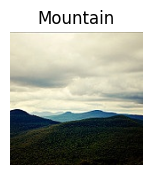

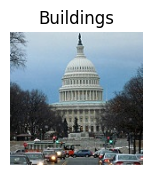

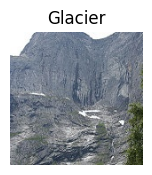

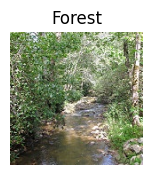

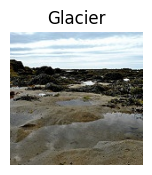

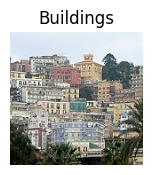

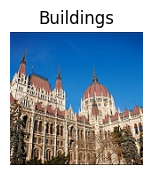

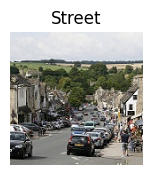

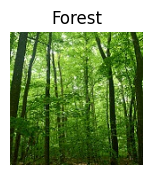

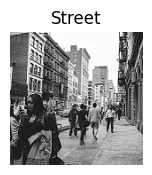

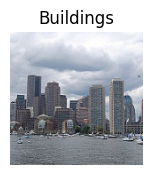

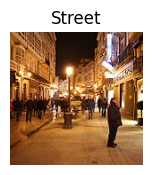

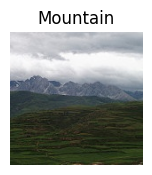

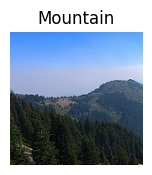

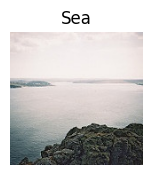

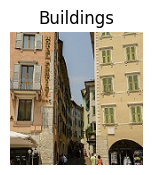

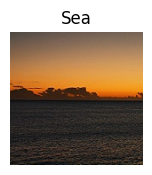

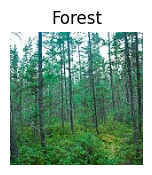

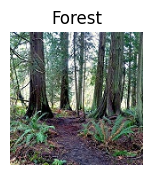

In [99]:
k =1
for i in num_list:
    file_path = f'/kaggle/input/intel-image-classification/seg_pred/seg_pred/{i}.jpg'
    if os.path.isfile(file_path):
        fig = plt.figure(figsize=(10, 10))
        image = Image.open(file_path)
        ax = plt.subplot(5,4,k)
        
        plt.imshow(image)
        plt.axis("off")
        predictions = import_and_predict(image,model)
        confidence = round(100*(np.max(predictions[0])),2)
        idx = np.argmax(predictions[0])
        #print(f"{class_names[idx]}")
        plt.title(class_names[idx])
        k=k+1
        if k == 20:
            break

In [100]:
import tensorflow as tf


# Specify the directory where you want to save the model
save_dir = '/kaggle/working/MODEL'

# Save the model
tf.saved_model.save(model, save_dir)


INFO:tensorflow:Assets written to: /kaggle/working/MODEL/assets


INFO:tensorflow:Assets written to: /kaggle/working/MODEL/assets


In [101]:
# Specify the path including the filename and extension
save_path = '/kaggle/working/model.h5'

# Save the model as an H5 file
model.save(save_path)